In [1]:
# Dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.config import load_config_nb
from itertools import product, combinations
from pyvirtualdisplay import Display
from pyomo.environ import ConcreteModel, Var, minimize, SolverFactory

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 3)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'

import yaml
from nocturne.envs.base_env import BaseEnv

### Helper functions

In [28]:
def collect_contraints(init_actions=None, max_steps=5, verbose=False, gamma=.99, num_rep_actions=1, agent_id=32):
    
    init_state = env.reset()[agent_id]

    print(f"Max actions: {max_steps}")

    # Define number of states, reward, transition matrix, and discount factor
    num_actions = env.action_space.n
    num_states = num_actions ** max_steps
    states = {}
    reward = {}
    transition = {}

    # Set initial reward
    reward[0] = 0

    # Get all possible action sequences
    #TODO: add optimal actions
    action_seqs = list(product(env.idx_to_actions, repeat=max_steps))

    # Iterate through all action sequences
    state_idx = 1
    for action_seq_idx, action_seq in enumerate(action_seqs):

        # Print progress
        if verbose:
            print(f"Action index: {action_seq_idx + 1} / {len(action_seqs)}")
            print(f"Action sequence: {action_seq}")
        else:
            print("\rAction index: {} / {}".format(action_seq_idx + 1, len(action_seqs)), end="")
        
        # Reset environment
        obs = env.reset()

        # Play initial actions: resume from last state
        for init_action in init_actions:
            obs, _, _, _ = env.step({agent_id: init_action})

        # Set initial state
        if action_seq_idx == 0:
            states[0] = init_state if init_actions is None else obs[agent_id]

        # Step through scene using action sequence
        for action_idx, action in enumerate(action_seq):
            
            # Reset reward for action
            total_reward = 0

            # Repeat action
            for _ in range(num_rep_actions):
                obs, rew, done, info = env.step({agent_id: action})
                total_reward += rew[agent_id]
                if done[agent_id]: # Stop if agent is done
                    total_reward += 10 if info[agent_id]['goal_achieved'] else -10
                    if verbose:
                        print("GOAL ACHIEVED!" if info[agent_id]['goal_achieved'] else "Oh no, the car crashed!")
                    break
            
            # Get next state
            next_state = obs[agent_id]

            # Store state, reward, and transition
            states[state_idx] = next_state
            reward[state_idx] = total_reward
            transition[((state_idx - 1) if (action_idx != 0) else 0, action)] = state_idx

            # Increment state index
            state_idx += 1

            if done[agent_id]:  # Stop if agent is done
                break
        if not done[agent_id] and verbose:
            print("The car is not done driving...")
        
        if verbose:
            print("\n")

    if not verbose:
        print("\n")

    return states, reward, transition


def solve_lp(states, reward, gamma, transition_array, num_actions):

    # Step 0: Create an instance of the model
    model = ConcreteModel()

    # Step 1: Define index sets
    states_set = list(range(len(states)))
    actions_set = list(range(num_actions))

    # Step 2: Define the decision 
    model.v = Var(states_set, initialize=0)

    # Step 3: Define Objective
    @model.Objective(sense=minimize)
    def objective(m):
        return sum([model.v[s] for s in states_set])

    # Step 4: Constraints
    @model.Constraint(states_set, actions_set)
    def state_value_constraint(m, s, a):
        return model.v[s] >= reward[s] + gamma * sum([transition_array[s, a, s2] * model.v[s2] for s2 in states_set])

    # Step 5: Solve
    results = SolverFactory('glpk').solve(model)
    return model

def get_sol_values(model):
    # Get LP solution values
    values = np.array([val.value for val in model.v.values()])

    # Find optimal path and actions
    opt_states = [0]
    opt_actions = []
    for _ in range(15):
        next_values = np.multiply(transition_array[opt_states[-1], :, :], values)
        if (next_values == 0).all():
            break
        opt_next = next_values.max(axis=0).argmax()
        opt_action = transition_array[opt_states[-1], :, opt_next].argmax()
        opt_states.append(opt_next)
        opt_actions.append(opt_action)

    # Display optimal path and actions
    df = pd.DataFrame(
        index = opt_states,
        data = {
            "x": [states[state_idx][0] for state_idx in opt_states],
            "y": [states[state_idx][1] for state_idx in opt_states],
            "speed": [states[state_idx][2] for state_idx in opt_states],
            "angle": [states[state_idx][3] for state_idx in opt_states],
            "value": [values[state_idx] for state_idx in opt_states],
            "action": [*[opt_action for opt_action in opt_actions], None],
        },
    )
    return df

def remove_duplicates(states):
    # Remove duplicate states
    states_df = pd.DataFrame(
        index = states.keys(),
        data = states.values(),
        columns = ["x", "y", "speed", "angle"],
    )
    states_full_df = pd.merge(
        left = states_df,
        right = states_df.drop_duplicates().reset_index(drop=True).reset_index().rename(columns={"index": "state_map"}),
        how = "left",
        on = ["x", "y", "speed", "angle"],
    )
    state_map = states_full_df["state_map"].to_dict()

    return state_map

### Settings

In [29]:
GOAL_TOL = 0.25

env_config = load_config_nb("env_config")
video_config = load_config_nb("video_config")

env_config.data_path = "../data_lp/"
env_config.subscriber.use_observations = False
env_config.subscriber.use_ego_state = False
env_config.subscriber.use_current_position = True # Use position, speed, ...
env_config.normalize_state = False
env_config.rew_cfg.position_target_tolerance = GOAL_TOL

# Action space
env_config.accel_discretization = 2
env_config.steering_discretization = 3
env_config.accel_lower_bound = 0.0
env_config.accel_upper_bound = 1.0
env_config.steering_lower_bound = -0.5
env_config.steering_upper_bound = 0.5

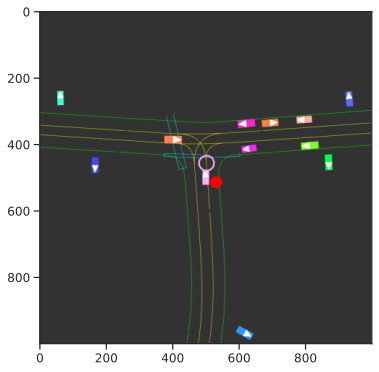

In [30]:
env = BaseEnv(env_config)
env.reset()
veh_obj = env.controlled_vehicles[0]
# Render
with Display(backend="xvfb") as disp:
    scene_img = env.scenario.getImage(
        img_width=1000,
        img_height=1000,
        padding=0,
        draw_target_positions=True,
        source=veh_obj,
        view_width=100,
        view_height=100,
        rotate_with_source=True,
    )

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(scene_img);

### Formulate LP

#### **Steps**
1. **Generate the set of possible action sequences** 

\begin{align*}
    \mathcal{A} &= \{ (a_{t=0}, a_{t=1}, ..., a_{t=T}), ... , (a_{t=0}, a_{t=1}, ..., a_{t=T}) \} \\
                &= \{ (0, 0, ..., 0), ... , (A, A, .., A) \}
\end{align*}

where we take the number of possible actions $A = 3$ and $T =8$ as the maximum sequence length (the number of steps).
    
2. **Generate the set of states by stepping the environment with every action sequence**

    - We step the environment with each action sequence and store the states and respective rewards

$$$$

3. **Remove duplicate states**

    - The combined set of action sequences will result in state redundancy, we remove all duplicate states 


___

_*_ Formulating this problem is NP-hard 

_*_ NOTE: We currently set the maximum sequence length $T$ to 8, because the time complexity for `itertools.product()` is O(m*n), where m and n are the sizes of the two lists -- (cartesian product, equivalent to a nested for-loop).

In [31]:
# Make environment
env = BaseEnv(env_config)
env.reset()
num_actions = env.action_space.n

# Seclect vehicle
veh_obj = env.controlled_vehicles[0]
print(f'Controlling veh: {veh_obj.id}')

# Obtain human driver trajectory
expert_coords_x = []
expert_coords_y = []
expert_acc = []
expert_steer = []
expert_speed = []

GOAL_POS = veh_obj.target_position

veh_obj.expert_control = True
for t in range(80):
    expert_coords_x.append(veh_obj.position.x)
    expert_coords_y.append(veh_obj.position.y)
 
    expert_action = env.scenario.expert_action(veh_obj, t)
    expert_acc.append(expert_action.acceleration)
    expert_steer.append(expert_action.steering)
    expert_speed.append(veh_obj.speed)

    env.step({})

veh_obj.expert_control = False
env.reset()

Controlling veh: 3


{3: array([ 9.03282031e+03, -2.71831323e+03,  1.10296458e-01,  0.00000000e+00])}

In [32]:
gamma = 0.99
max_steps = 3
iters = 64 // max_steps
timestep = 0

df_all = pd.DataFrame(columns=["x", "y", "speed", "angle", "value", "action"])
init_actions = []

for iter in range(iters):

    print(f"ITERATION {iter + 1} / {iters}")

    ### Formulate the LP ###
    states, reward, transition = collect_contraints(init_actions=init_actions, max_steps=max_steps, verbose=False, num_rep_actions=1, agent_id=veh_obj.id)

    state_map = remove_duplicates(states)

    # Remap states, rewards, and transitions
    states = {state_map[state_idx]: state for state_idx, state in states.items()}
    reward = {state_map[state_idx]: rew for state_idx, rew in reward.items()}
    transition = {(state_map[state_idx], action): state_map[next_state_idx] for (state_idx, action), next_state_idx in transition.items()}

    # Convert transition to 3D numpy array
    transition_array = np.zeros((len(states), num_actions, len(states)))
    for (state_idx, action), next_state_idx in transition.items():
        transition_array[state_idx, action, next_state_idx] = 1

    ### Solve LP ### 
    model = solve_lp(states, reward, gamma, transition_array, num_actions)

    ### Get solution values ###
    df_sol = get_sol_values(model)
    init_actions.extend(df_sol['action'][:-1].tolist())

    # Append new values
    df_all = pd.concat(objs=[df_all, df_sol.iloc[:-1, :]]).reset_index(drop=True)
    timestep += max_steps

    
# Add last row
#df_all.loc[len(df_all), :] = df_sol.iloc[-1, :]

ITERATION 1 / 21
Max actions: 3
Action index: 216 / 216



/tmp/ipykernel_3072671/1013432136.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(objs=[df_all, df_sol.iloc[:-1, :]]).reset_index(drop=True)


ITERATION 2 / 21
Max actions: 3
Action index: 216 / 216

ITERATION 3 / 21
Max actions: 3
Action index: 216 / 216

ITERATION 4 / 21
Max actions: 3
Action index: 216 / 216

ITERATION 5 / 21
Max actions: 3
Action index: 216 / 216

ITERATION 6 / 21
Max actions: 3
Action index: 216 / 216

ITERATION 7 / 21
Max actions: 3
Action index: 216 / 216

ITERATION 8 / 21
Max actions: 3
Action index: 216 / 216

ITERATION 9 / 21
Max actions: 3
Action index: 216 / 216

ITERATION 10 / 21
Max actions: 3
Action index: 216 / 216

ITERATION 11 / 21
Max actions: 3
Action index: 1 / 216

KeyError: 3

In [33]:
acc_val = []
steer_val = []
action_idx = df_all.action.values

for t in range(action_idx.shape[0]):
    acc, steer = env.idx_to_actions[action_idx[t]]

    acc_val.append(acc)
    steer_val.append(steer)

df_all['action_acc'] = acc_val
df_all['action_steer'] = steer_val

# Display optimal path and actions
display(df_all.style)

,x,y,speed,angle,value,action,action_acc,action_steer
0,9032.820312,-2718.313232,0.110296,0.000000,0.000627,4.000000,1.000000,0.000000
1,9032.831055,-2718.325439,0.210296,0.000000,0.000633,4.000000,1.000000,0.000000
2,9032.847656,-2718.345215,0.310296,0.000000,0.000562,4.000000,1.000000,0.000000
3,9032.871094,-2718.372803,0.410296,0.000000,0.002530,4.000000,1.000000,0.000000
4,9032.900391,-2718.407959,0.510296,0.000000,0.002556,4.000000,1.000000,0.000000
5,9032.936523,-2718.450684,0.610296,0.000000,0.001992,4.000000,1.000000,0.000000
6,9032.979492,-2718.500977,0.710297,0.000000,0.005681,4.000000,1.000000,0.000000
7,9033.028320,-2718.559082,0.810297,0.000000,0.005738,4.000000,1.000000,0.000000
8,9033.083984,-2718.624756,0.910297,0.000000,0.004267,4.000000,1.000000,0.000000
9,9033.146484,-2718.697998,1.010297,0.000000,0.010075,4.000000,1.000000,0.000000


In [ ]:
df_all['traffic_scene'] 

In [52]:
print(df_all.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
 & x & y & speed & angle & value & action & action_acc & action_steer \\
\midrule
0 & 9032.820312 & -2718.313232 & 0.110296 & 0.000000 & 0.000627 & 4.000000 & 1.000000 & 0.000000 \\
1 & 9032.831055 & -2718.325439 & 0.210296 & 0.000000 & 0.000633 & 4.000000 & 1.000000 & 0.000000 \\
2 & 9032.847656 & -2718.345215 & 0.310296 & 0.000000 & 0.000562 & 4.000000 & 1.000000 & 0.000000 \\
3 & 9032.871094 & -2718.372803 & 0.410296 & 0.000000 & 0.002530 & 4.000000 & 1.000000 & 0.000000 \\
4 & 9032.900391 & -2718.407959 & 0.510296 & 0.000000 & 0.002556 & 4.000000 & 1.000000 & 0.000000 \\
5 & 9032.936523 & -2718.450684 & 0.610296 & 0.000000 & 0.001992 & 4.000000 & 1.000000 & 0.000000 \\
6 & 9032.979492 & -2718.500977 & 0.710297 & 0.000000 & 0.005681 & 4.000000 & 1.000000 & 0.000000 \\
7 & 9033.028320 & -2718.559082 & 0.810297 & 0.000000 & 0.005738 & 4.000000 & 1.000000 & 0.000000 \\
8 & 9033.083984 & -2718.624756 & 0.910297 & 0.000000 & 0.004267 & 4.000000 & 1.000

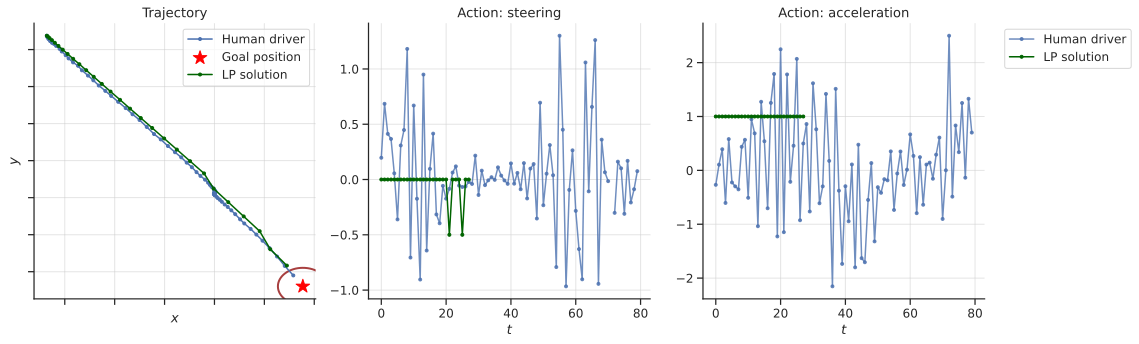

In [64]:
from matplotlib.patches import Circle

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Actions
axs[2].set_title(f'Action: acceleration')
axs[2].plot(expert_acc, '.-', label='Human driver', alpha=.8)
axs[2].plot(df_all.action_acc.values, '.-', label='LP solution', color='darkgreen', )
axs[2].set_xlabel(r'$t$')

# Actions
axs[1].set_title(f'Action: steering')
axs[1].plot(expert_steer, '.-', label='Human driver', alpha=.8)
axs[1].plot(df_all.action_steer.values, '.-', label='LP solution', color='darkgreen')
axs[1].set_xlabel(r'$t$')

# Trajectory
axs[0].set_title(f'Trajectory')
axs[0].plot(expert_coords_x, expert_coords_y, '.-', label='Human driver')
axs[0].scatter(GOAL_POS.x, GOAL_POS.y, marker='*', color='red', s=200, label='Goal position')
axs[0].plot(df_all['x'], df_all['y'], '.-', color='darkgreen', label='LP solution')
#axs[0].annotate('Goal', (GOAL_POS.x, GOAL_POS.y), textcoords="offset points", xytext=(6, 25), ha='center', fontsize=15)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([]) 
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$y$')

# Drawing a circle around the goal position
circle = Circle((GOAL_POS.x, GOAL_POS.y), radius=GOAL_TOL, color='darkred', linewidth=2, alpha=.75, fill=False)
axs[0].add_patch(circle)

axs[0].legend(loc='upper right', fancybox=True, facecolor='white')
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].grid(True, alpha=0.5), axs[1].grid(True, alpha=0.5), axs[2].grid(True, alpha=0.5)

plt.tight_layout()
sns.despine()

plt.savefig(f'/home/emerge/daphne/nocturne_lab/data_lp/figures/trajectory_lp.pdf', bbox_inches='tight', dpi=300)

### Plot

In [18]:
# Load csv
df = pd.read_csv("lp_benchmark.csv")

# Make environment
env = BaseEnv(env_config)
env.reset()
veh_obj = env.controlled_vehicles[0]

In [64]:
df

,Unnamed: 0,x,y,speed,angle,value,action
0,0,9047.629883,-2720.589111,3.511181,0.0,0.101165,1.0
1,116,9047.358398,-2720.812256,3.511181,0.0,0.101165,1.0
2,142,9047.086914,-2721.035400,3.511181,0.0,0.081360,1.0
3,153,9046.815430,-2721.258545,3.511181,0.0,0.061341,1.0
4,158,9046.543945,-2721.481689,3.511181,0.0,0.041108,1.0
5,160,9046.272461,-2721.704834,3.511181,0.0,0.020661,NaN


In [57]:
# Render scene
with Display(backend="xvfb") as disp:
    scene_img = env.scenario.getImage(
        img_width=1200,
        img_height=1200,
        padding=0,
        draw_target_positions=True,
        source=veh_obj,
        view_width=100,
        view_height=100,
        rotate_with_source=True,
    )

    cone_img = env.scenario.getConeImage(
        source=veh_obj,
        view_dist=80,
        view_angle=np.pi,
        head_angle=0,
        img_width=2000,
        img_height=2000,
        padding=0.,
        draw_target_position=True,
    )

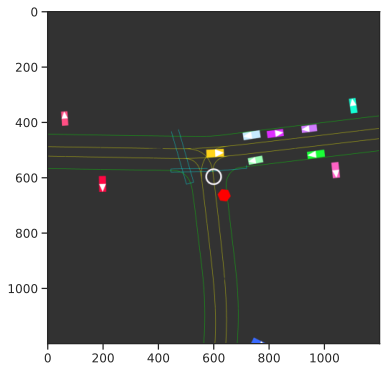

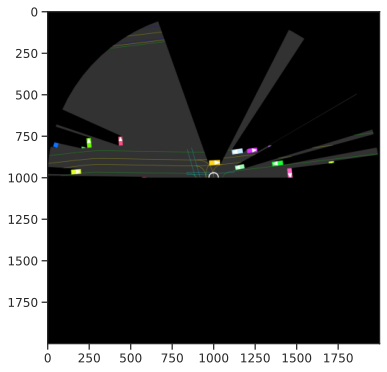

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(scene_img);

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(cone_img);